In [1]:
import ctypes

In [2]:
basic_dll = ctypes.CDLL('fourier_basic.so')

In [3]:
basic_dll.density_fourier_capi_float.restype = ctypes.c_int
basic_dll.density_fourier_capi_float.argtypes = [ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_long, ctypes.c_long, ctypes.c_float, ctypes.c_float]
basic_dll.density_fourier_capi_double.restype = ctypes.c_int
basic_dll.density_fourier_capi_double.argtypes = [ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_long, ctypes.c_long, ctypes.c_double, ctypes.c_double]

In [4]:
import numpy as np

In [5]:
def density_fourier_float(data: np.array, hcount = 32):
    fp_data = np.ascontiguousarray(data, dtype = np.float32)
    scount = len(fp_data)
    re_harm, im_harm = np.zeros(hcount, dtype = np.float32), np.zeros(hcount, dtype = np.float32) 
    dmin, dmax = np.min(data), np.max(data)
    shift, basek = 0.5 * (dmax + dmin), 2 * np.pi / np.abs(dmax - dmin)
    res = basic_dll.density_fourier_capi_float(  \
        fp_data.ctypes.data_as(ctypes.c_void_p), \
        re_harm.ctypes.data_as(ctypes.c_void_p), \
        im_harm.ctypes.data_as(ctypes.c_void_p), \
        scount, hcount, shift, basek)
    assert res == 0
    return (re_harm, im_harm)

def density_fourier_double(data: np.array, hcount = 32):
    fp_data = np.ascontiguousarray(data, dtype = np.float64)
    scount = len(fp_data)
    re_harm, im_harm = np.zeros(hcount, dtype = np.float64), np.zeros(hcount, dtype = np.float64) 
    dmin, dmax = np.min(data), np.max(data)
    shift, basek = 0.5 * (dmax + dmin), 2 * np.pi / np.abs(dmax - dmin)
    res = basic_dll.density_fourier_capi_double( \
        fp_data.ctypes.data_as(ctypes.c_void_p), \
        re_harm.ctypes.data_as(ctypes.c_void_p), \
        im_harm.ctypes.data_as(ctypes.c_void_p), \
        scount, hcount, shift, basek)
    assert res == 0
    return (re_harm, im_harm)

def density_fourier(data: np.array, hcount = 16):
    if data.dtype == np.float32:
        return density_fourier_float(data, hcount)
    if data.dtype == np.float64:
        return density_fourier_double(data, hcount)
    return None

In [6]:
nx = 5000000
xs = 2 * np.random.rand(nx) - 1
ys = np.random.rand(nx)
fs = np.exp(-4 *(xs-0.9)**2) + np.exp(-100*(xs+0.9)**2) + np.exp(-50*(xs+0.3)**2)
#fs = 0.5 + 0.5 * np.sin(4 * np.pi * xs)
zs = xs[ys < fs]
zsf, zsd = zs.astype(dtype = np.float32), zs.astype(dtype = np.float64) 
nz = zs.shape[0]

In [7]:
import matplotlib.pyplot as plt

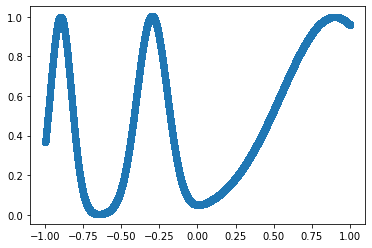

In [8]:
plt.scatter(xs, fs)

In [9]:
print(nz)

2391049


In [10]:
re_harm, im_harm = density_fourier(zs)

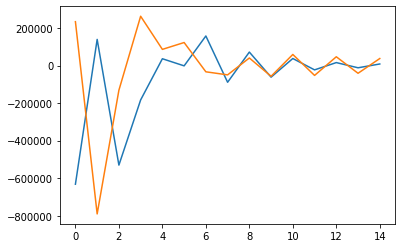

In [11]:
plt.plot(re_harm[1:])
plt.plot(im_harm[1:])

In [12]:
basic_dll.evaluate_fourier_capi_float.restype = ctypes.c_float
basic_dll.evaluate_fourier_capi_float.argtypes = [ctypes.c_float, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_long, ctypes.c_float, ctypes.c_float]
basic_dll.evaluate_fourier_capi_double.restype = ctypes.c_double
basic_dll.evaluate_fourier_capi_double.argtypes = [ctypes.c_double, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_long, ctypes.c_double, ctypes.c_double]

In [13]:
def evaluate_fourier_float(arg: float, 
                           reharmonics: np.array, imharmonics: np.array, 
                           shift = 0.0, basek = np.pi) -> float:
    assert (imharmonics.ndim == 1) and (reharmonics.ndim == 1)
    assert imharmonics.shape == reharmonics.shape
    reh = np.ascontiguousarray(reharmonics, dtype = np.float32)
    imh = np.ascontiguousarray(imharmonics, dtype = np.float32)
    hcount = len(imh)
    return basic_dll.evaluate_fourier_capi_float(     \
                arg,                                  \
                reh.ctypes.data_as(ctypes.c_void_p),  \
                imh.ctypes.data_as(ctypes.c_void_p),  \
                hcount, shift, basek) / reharmonics[0]

def evaluate_fourier_double(arg: float, 
                            reharmonics: np.array, imharmonics: np.array, 
                            shift = 0.0, basek = np.pi) -> float:
    assert (imharmonics.ndim == 1) and (reharmonics.ndim == 1)
    assert imharmonics.shape == reharmonics.shape
    reh = np.ascontiguousarray(reharmonics, dtype = np.float64)
    imh = np.ascontiguousarray(imharmonics, dtype = np.float64)
    hcount = len(imh)
    return basic_dll.evaluate_fourier_capi_double(   \
                arg,                                  \
                reh.ctypes.data_as(ctypes.c_void_p),  \
                imh.ctypes.data_as(ctypes.c_void_p),  \
                hcount, shift, basek) / reharmonics[0]

def evaluate_fourier(arg: float, 
                     reharmonics: np.array, imharmonics: np.array, 
                     shift = 0.0, basek = np.pi):
    assert imharmonics.dtype == reharmonics.dtype
    if (imharmonics.dtype == np.float32) and (reharmonics.dtype == np.float32):
        return evaluate_fourier_float(arg, reharmonics, imharmonics, shift, basek)
    if (imharmonics.dtype == np.float64) and (reharmonics.dtype == np.float64):
        return evaluate_fourier_double(arg, reharmonics, imharmonics, shift, basek)
    return None

In [14]:
xs = np.linspace(-1., 1., 1000)
func = lambda x: evaluate_fourier(x, re_harm, im_harm)
ys = np.array([func(x) for x in xs])

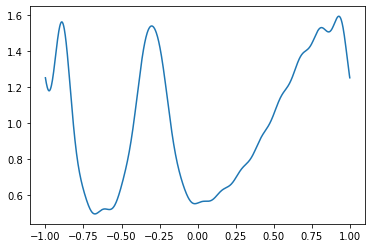

In [15]:
plt.plot(xs, ys)

In [16]:
from time import *

In [17]:
def time_it(func):
    s = perf_counter()
    func()
    e = perf_counter()
    return (e - s)

In [18]:
def box_filter(func, iters = 32, bs = (0.25, 0.5)):
    times = np.array([time_it(func) for i in range(iters)])
    times = np.sort(times)
    ifrom, ito = int(iters * bs[0]), int(iters * bs[1])
    filtered = times[ifrom:ito]
    return np.mean(filtered), np.std(filtered)

In [19]:
i = 1
points, ftimes, dtimes = [], [], []
while (i < 20) and (2**i < nz):
    i = i + 1
    npoints = int(2**i)
    dataf, datad = zsf[:npoints], zsd[:npoints]
    funcf = lambda: density_fourier(dataf)
    resf, devf = box_filter(funcf)
    funcd = lambda: density_fourier(dataf)
    resd, devd = box_filter(funcd)
    points.append(npoints)
    ftimes.append(resd)
    dtimes.append(resf)

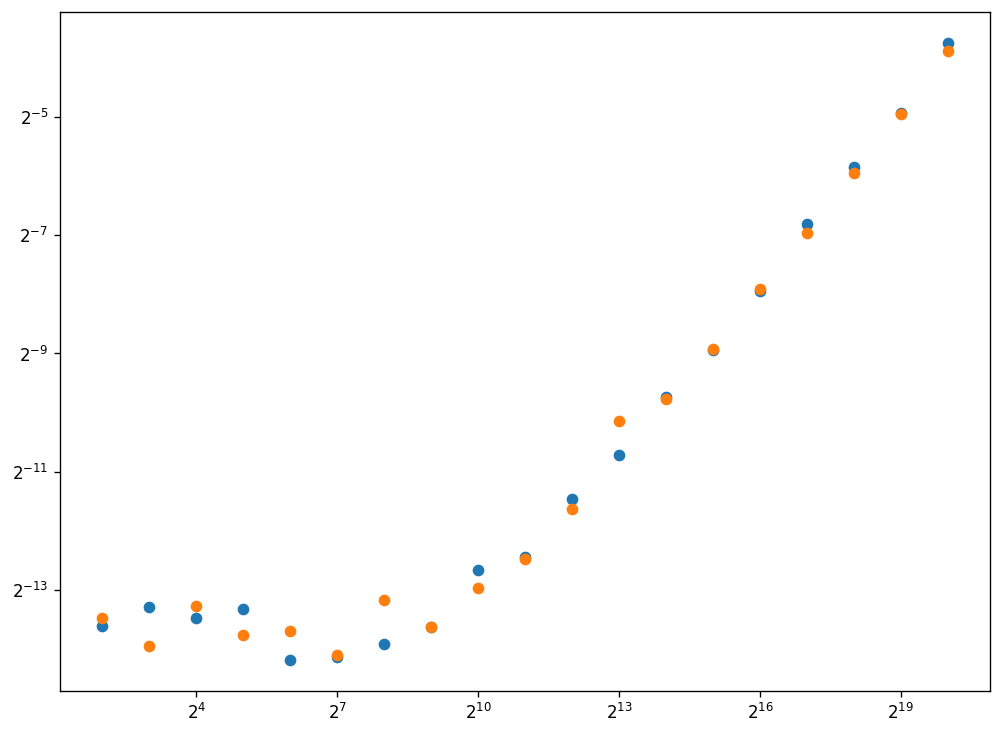

In [20]:
plt.figure(figsize = (10, 7.5), dpi = 120)
plt.xscale('log', basex = 2)
plt.yscale('log', basey = 2)
plt.scatter(points, ftimes)
plt.scatter(points, dtimes)